# Problem definition: Segmentation of gliomas in MRI scans

In this jupyter notebook, we will be doing whole tumor (WT) segmentation. WT includes subregions 1, 2 and 4.



Each pixel on image is labelled as :

- Pixel is part of a tumor area (subregions: 1, 2, 4)
- Pixel is not a part of tumor area (0)

where, 0 - no tumor, 1 - necrotic/core/ non-enhancing, 2 - edema, 4 - enhancing


**Objectivies (What will we learn here?)**
1. Setting up the env
2. Create training, validation and test ids
3. Image pre-processing
4. Performance metrics for semantic segmentation
5. Loss functions for semantic segmentation
6. Building the Unet model
7. Training the model
8. Looking at the learning curve
9. Predicting using the Unet model
10. What next? It is time to play!




## Step 1: Set up the env

Download all the packages needed.

In [74]:
import os
import numpy as np
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import random

Because we are working on data stored in Google Cloud Storage bucket, the following steps will need to be taken:

1. Install [gcsfuse](https://colab.research.google.com/drive/19slw0Fl_kDJmaL5NIZ71bxagv5vxq55v#scrollTo=r0VPeE7kMIgW&line=3&uniqifier=1) it is a package used to mount the cloud bucket on to your local environment.
2. Authenticate your google account
3. Create a new directory to mount the storage bucket
4. Use gcsfuse to mount the storage bucket

You can browse throught the storage bucket here

In [2]:
!apt-get update -y && apt-get install -y fuse lsb-release; \
    curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v0.41.12/gcsfuse_0.41.12_amd64.deb; \
    dpkg --install gcsfuse_0.41.12_amd64.deb; \
    apt-get update; \
    apt-get clean;

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,197 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,632 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,448 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:13 http://security.ubuntu.

Now call google authentication with the following code block and allow access in the pop-up window


In [3]:
from google.colab import auth
auth.authenticate_user()

Let's set the project id and storage bucket id

In [4]:
project_id = 'sfsu-378805'
bucket_name = 'csc-509-image-files'
!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



You can list using gsutil to see if we have the correct storage

---



In [5]:
!gsutil ls

gs://csc-509-image-files/


Let's make a new directory called images to mount our bucket

In [6]:
!mkdir images

Call gcsfuse to mount the bucket


In [7]:
!gcsfuse --implicit-dirs csc-509-image-files images

2025/01/02 20:36:50.853798 Start gcsfuse/0.41.12 (Go version go1.18.4) for app "" using mount point: /content/images
2025/01/02 20:36:50.870579 Opening GCS connection...
2025/01/02 20:36:52.162129 Mounting file system "csc-509-image-files"...
2025/01/02 20:36:52.163005 File system has been successfully mounted.


In [8]:
!ls images/

Archive				Module0_UPENNGBM  Module1_BraTS.tar.bz2  Module2_ADNI_New
Module0_DataCuration		Module1_ADNI	  Module1_PET
Module0_MRI_PET_Classification	Module1_BraTS	  Module2_ADNI


## Step 2: Now let's create the training, validation and test ids.


In [9]:
# Let's define the train data path.
TRAIN_DATA_PATH = Path('/content/images/Module1_BraTS/MICCAI_BraTS2020_TrainingData')

# BraTS also has "ValidationData" which has only images and no segmentation masks. So we won't be using it in this notebook.


In [10]:
# Let's create the training, validation and test ids.

train_dir = [f.path for f in os.scandir(TRAIN_DATA_PATH) if f.is_dir()]

# We will create train, validation and test ids from the train_dir dataset


def list_to_ids(dir:str):
    """
    Will convert the dir paths to ids by parsing the paths.
    dir: string, image dir paths in BRATS
    """
    x = []
    for i in range(0,len(dir)):
        x.append(dir[i].split('/')[-1])
    return x



How to do train-test-split using sklearn: https://www.stackvidhya.com/train-test-split-using-sklearn-in-python/

In [11]:
# Now let's use the defined function

ids = list_to_ids(train_dir)

# Split dataset to create training ids, validation ids and test ids
# Here we have selected the size of test set as 20% which is a common practice.
train_ids, test_ids = train_test_split(ids,test_size=0.2)

# Create validation ids by further splitting the train ids, we again use 20% as size of validation set.
# Validation set is also referred to as tuning set.

train_ids, val_ids = train_test_split(train_ids,test_size=0.2)

In [12]:
# Now looks at the number of patient ids in training, validation and test sets
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')

There are 236 patient ids in training set
There are 59 patient ids in validation set
There are 74 patient ids in test set


## Step 3: Let's do some image pre-processing. You have already learnt basics of reading and visualizing nifti images, selecting slices and looking at histograms.

Here, we will look at some pre-processing steps specific to semantic segmentation. It's important to understand that the pro-processing steps could vary depending on the task at hand.


In [13]:
# Let's rewind and remember the type of images available: T1, T1CE, T2, FLAIR and corresponding masks

# We will use the read_patient_niftis module we had learnt in the previous notebook
def read_patient_niftis(patient_id: str,
                        niftis_to_load = ['t1', 't1ce', 't2', 'flair', 'seg'],
                        data_path = TRAIN_DATA_PATH):
  """
  Will read in the images from a single patient and return a dictionary of
  those images with the key as the image type and the value as the nifti object.
  patient_id: string of format '001' through '369', patient ID in BRATS
  niftis_to_load: default is list containing all the types of images that we care about; can sub in another list if desired.
  data_path: default is DATA_PATH specified above with respect to the mounted google drive (in colab)

  """
  patient_image_dict = {}
  for image in niftis_to_load:
    patient_image_dict[image]=nib.load(Path(data_path, f'{patient_id}', f'{patient_id}_{image}.nii.gz'))
  return patient_image_dict


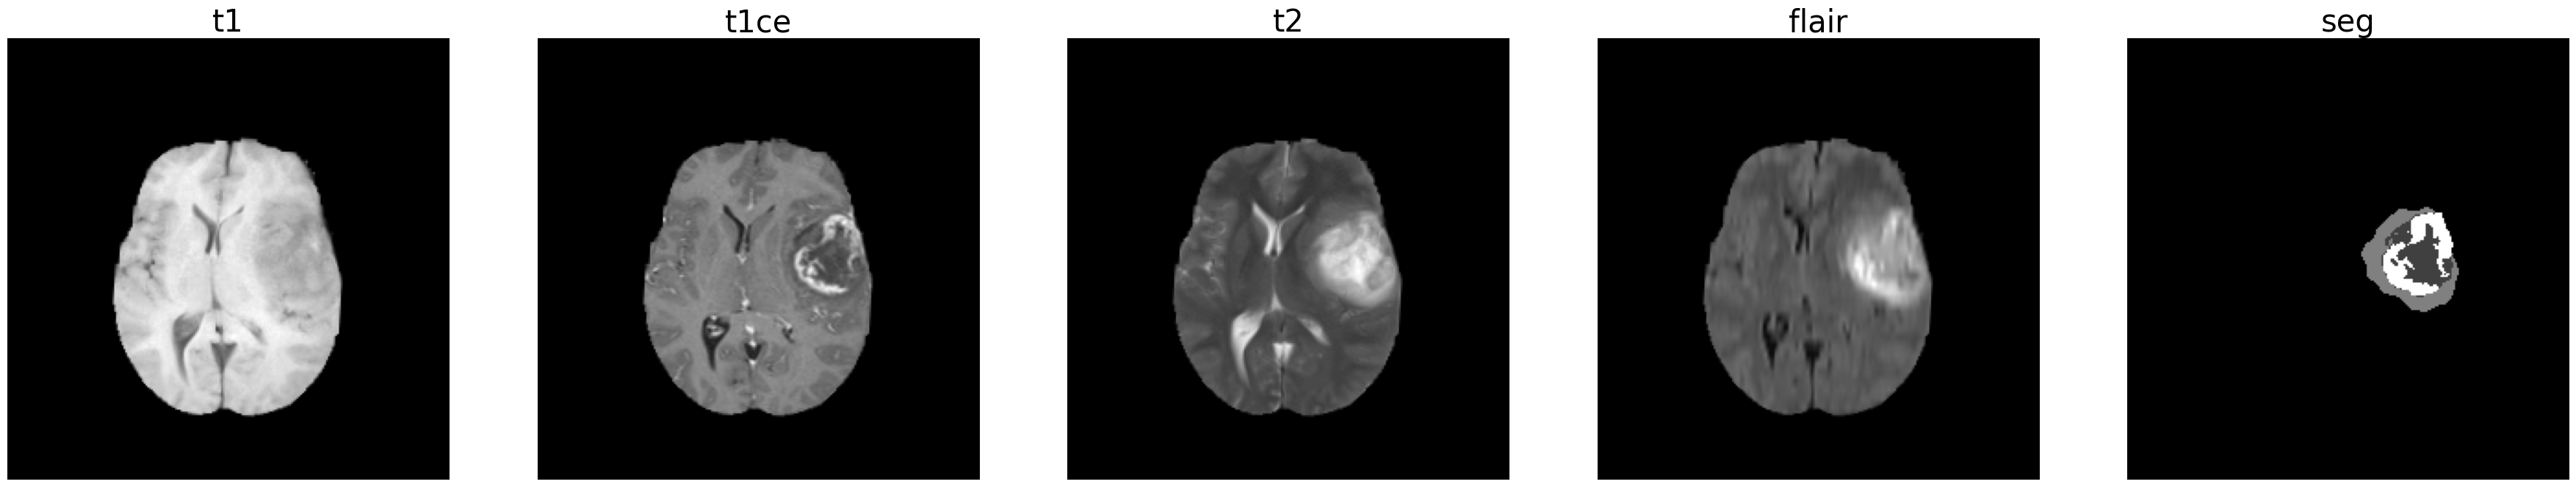

In [14]:
# Let's take a look one of the image and the corresponding segmentation mask from the training set before we proceed
pt_img_dict = read_patient_niftis(train_ids[12])

# Now lets visualize all the images side by side to get a sense of what's happening.
plt.figure(figsize=(45,30)) # specifying the overall grid size
for i, (key, value) in enumerate(pt_img_dict.items()):
    plt.subplot(1, 5, i+1)
    plt.imshow(value._dataobj[:, :, value.shape[-1]//2].T, cmap='gray') # Looks halfway through the volume and transposes the image so that its facing upward.
    plt.axis('off')
    plt.title(key, fontsize=30)
plt.show()

A quick recap on MRI basics: https://my-ms.org/mri_basics.html

In [50]:
# For this semantic segmentation task, we will use T2 images.
# And we will focus on binary or whole tumor (WT) segmentation. In order to do so we will assign the same pixel intensity (1) to the 3 tumor sub regions (1, 2, 4)

def normalize(input_image, input_mask, percentile=0.001, eps=1e-6):
    """
    Normalize the input image between 0 and 1 and prepare the mask for binary segmentation.

    input_image: The image to be segmented.
    input_mask: The ground truth or label.
    """
    # Convert input image to a PyTorch tensor if it's not already
    if not isinstance(input_image, torch.Tensor):
        input_image = torch.tensor(input_image, dtype=torch.float32)

    # Ensure the tensor is contiguous before reshaping
    img_array = input_image.contiguous().view(-1)

    # Calculate the min and max based on the percentiles
    min_img = torch.quantile(img_array, percentile)
    max_img = torch.quantile(img_array, 1 - percentile)

    # Normalize the image
    img_normalized = (input_image - min_img) / (max_img - min_img + eps)

    # Ensure the image is in the range [0, 1]
    img_normalized = torch.clamp(img_normalized, 0, 1)

    # Convert image to float tensor if not already
    img_normalized = img_normalized.float()

    # Process the mask
    if not isinstance(input_mask, torch.Tensor):
        input_mask = torch.tensor(input_mask, dtype=torch.int32)
    mask_normalized = torch.where(input_mask >= 1, 1, 0)

    return img_normalized, mask_normalized

In [51]:
# Example usage
# Assuming pt_img_dict['t2'] and pt_img_dict['seg'] are loaded as PyTorch tensors
t2_img = torch.tensor(pt_img_dict['t2'].get_fdata(), dtype=torch.float32)
seg_img = torch.tensor(pt_img_dict['seg'].get_fdata(), dtype=torch.int32)

img_normalized, mask_normalized = normalize(t2_img, seg_img)

Why is image normalizaton needed: https://arthurdouillard.com/post/normalization/

What are the different types of normalization: https://towardsdatascience.com/different-types-of-normalization-in-tensorflow-dac60396efb0

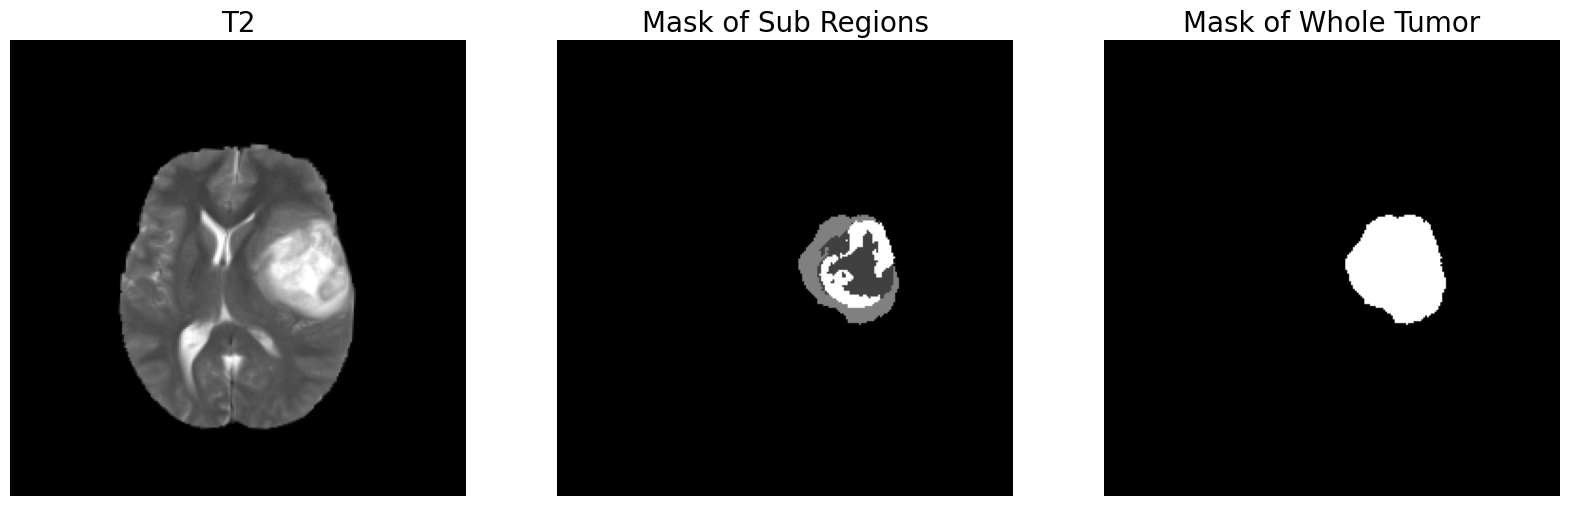

In [17]:
# Convert PyTorch tensors to NumPy arrays for plotting
img_np = img_normalized.cpu().numpy()
mask_np = mask_normalized.cpu().numpy()

# Visualize the images
plt.figure(figsize=(20, 30))

# Original T2 image
plt.subplot(1, 3, 1)
plt.imshow(img_np[:, :, 78].T, cmap='gray')  # Assuming the third dimension is the slice axis
plt.axis('off')
plt.title('T2', fontsize=20)

# Original segmentation mask
plt.subplot(1, 3, 2)
plt.imshow(seg_img[:, :, 78].T, cmap='gray')  # Directly using seg_img if it's already a NumPy array
plt.axis('off')
plt.title('Mask of Sub Regions', fontsize=20)

# Normalized mask
plt.subplot(1, 3, 3)
plt.imshow(mask_np[:, :, 78].T, cmap='gray')
plt.axis('off')
plt.title('Mask of Whole Tumor', fontsize=20)

plt.show()

## Step 4: Let's take a look at the performance metrics commonly used in semantic segmentation.

The 2 common ones are
- Dice
- Jaccard/Intersection of Union (IoU)

Both Dice and Jaccard indices are bounded between 0 and 1 with 0 indicating completely inaccurate model prediction and 1 indicating completely accurate model prediction.

Performance metrics in image segmentation: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

In [18]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    """
    Dice coefficient for semantic segmentation.

    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))

    y_true: The ground truth tensor.
    y_pred: The predicted tensor.
    smooth: Smoothing factor to avoid division by zero.
    """
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def jaccard_coef(y_true, y_pred, smooth=1e-6):
    """
    Jaccard coefficient for semantic segmentation. Also known as the IoU loss.

    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))

    y_true: The ground truth tensor.
    y_pred: The predicted tensor.
    smooth: Smoothing factor to avoid division by zero.
    """
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() - intersection + smooth)

## Step 5: Let's take a look at loss functions for semantic segmentation.

The default choice of loss function for segmentation and other classification tasks is Binary Cross-Entropy (BCE). Here since the metric  Dice or Jaccard Coefficient is being used to judge model performance, the loss functions that are derived from these metrics - typically in the form 1 - f(x) where f(x) is the metric in question.

Loss functions in image segmentation: https://medium.com/@junma11/loss-functions-for-medical-image-segmentation-a-taxonomy-cefa5292eec0

In [19]:
def dice_coef_loss(y_true, y_pred):
    """
    Dice loss for semantic segmentation.
    Minimizing this loss corresponds to maximizing the Dice coefficient.
    """
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef_loss(y_true, y_pred):
    """
    Jaccard loss for semantic segmentation.
    Minimizing this loss corresponds to maximizing the Jaccard coefficient.
    """
    return 1 - jaccard_coef(y_true, y_pred)

## Step 6: Now comes the most interesing bit of our learning!

We will now build the Unet model we are going to use for semantic segmentation of WT.

What is a UNet: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

Video explaining UNet: https://www.youtube.com/watch?v=azM57JuQpQI


In [20]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels)
            )

        self.down1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.center = conv_block(512, 1024)

        self.up4 = conv_block(1024 + 512, 512)
        self.up3 = conv_block(512 + 256, 256)
        self.up2 = conv_block(256 + 128, 128)
        self.up1 = conv_block(128 + 64, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Downsample
        down1 = self.down1(x)
        pool1 = self.pool1(down1)

        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        down3 = self.down3(pool2)
        pool3 = self.pool3(down3)

        down4 = self.down4(pool3)
        pool4 = self.pool4(down4)

        # Center
        center = self.center(pool4)

        # Upsample
        up4 = F.interpolate(center, scale_factor=2, mode='bilinear', align_corners=True)
        up4 = torch.cat([up4, down4], dim=1)
        up4 = self.up4(up4)

        up3 = F.interpolate(up4, scale_factor=2, mode='bilinear', align_corners=True)
        up3 = torch.cat([up3, down3], dim=1)
        up3 = self.up3(up3)

        up2 = F.interpolate(up3, scale_factor=2, mode='bilinear', align_corners=True)
        up2 = torch.cat([up2, down2], dim=1)
        up2 = self.up2(up2)

        up1 = F.interpolate(up2, scale_factor=2, mode='bilinear', align_corners=True)
        up1 = torch.cat([up1, down1], dim=1)
        up1 = self.up1(up1)

        # Final Classification Layer
        final = self.final(up1)
        return torch.sigmoid(final)

Instead of constant learning rate, how to use a gradually decreasing learning rate instead: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

Lets visualize the model now!

In [21]:
pip install torchviz

In [22]:
from torchviz import make_dot

In [23]:
model = UNet()

In [24]:
# Create a random tensor with the same size as your input
x = torch.randn(1, 1, 128, 128)  # Example input size

# Forward pass to generate the graph
y = model(x)

# Use make_dot to create a visualization
model_graph = make_dot(y, params=dict(model.named_parameters()))

# Save or display the graph
model_graph.format = 'png'
model_graph.render('unet_model')

# Display the graph in the notebook (if using Jupyter)
# display(model_graph)

'unet_model.png'

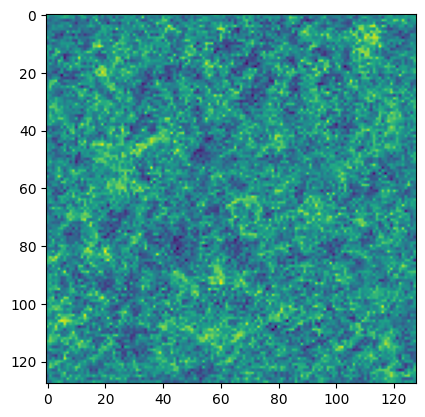

In [31]:
plt.imshow(y.detach().numpy()[0, 0, :,:])

## Step 7: Let's do some model training now.

In [94]:
class BraTSDataset(Dataset):
    def __init__(self, patient_ids, data_path, niftis_to_load=['t1', 't2', 'flair', 'seg'], transform=None):
        self.patient_ids = patient_ids
        self.data_path = data_path
        self.transform = transform
        self.niftis_to_load = niftis_to_load

    def __len__(self):
        return len(self.patient_ids)

    def find_random_non_empty_slice(self, mask_volume):
        """
        Find a random slice index in the mask volume that contains at least one non-zero pixel.
        """
        # Get all slice indices with non-zero pixels
        non_empty_slices = [i for i in range(mask_volume.shape[2]) if torch.any(mask_volume[:, :, i] != 0)]

        if not non_empty_slices:
            raise ValueError("No non-empty slices found in the mask volume.")

        # Randomly select one of the non-empty slice indices
        return random.choice(non_empty_slices)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        pt_img_dict = read_patient_niftis(patient_id, niftis_to_load=self.niftis_to_load, data_path=self.data_path)

        # Load the 't2' image and 'seg' mask
        t2_img = pt_img_dict['t2'].get_fdata()
        seg_img = pt_img_dict['seg'].get_fdata()

        # Normalize images
        img, mask = normalize(t2_img, seg_img)

        # Convert to tensors if not already
        img = img.clone().detach().requires_grad_(True).float()
        mask = mask.clone().detach().float()

        # Find a random non-empty slice
        slice_idx = self.find_random_non_empty_slice(mask)

        # Select the slice from the image and mask
        img_slice = img[:, :, slice_idx]
        mask_slice = mask[:, :, slice_idx]

        if self.transform:
            img_slice = self.transform(img_slice)
            mask_slice = self.transform(mask_slice)

        return img_slice, mask_slice

In [95]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL Image if starting from NumPy array
    transforms.Resize((128, 128)),
    transforms.ToTensor()  # This will scale pixel values to [0, 1]
    # Optional: If you want to normalize to zero mean and unit variance, specify mean and std
])

In [96]:
# Assuming that `train_ids`, `val_ids`, `test_ids`, and `TRAIN_DATA_PATH` are defined
train_dataset = BraTSDataset(train_ids, TRAIN_DATA_PATH, niftis_to_load = ['t2', 'seg'], transform=transform)
val_dataset = BraTSDataset(val_ids, TRAIN_DATA_PATH, niftis_to_load = ['t2', 'seg'], transform=transform)
test_dataset = BraTSDataset(test_ids, TRAIN_DATA_PATH, niftis_to_load = ['t2', 'seg'], transform=transform)


In [97]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Now we will read the .npy files and start our model training!We have a numpy arrays already created and saved

In [98]:
# Let's confirm the size of the training, validation and test arrays.
print(f'There are {len(train_dataset)} images in training set')
print(f'There are {len(val_dataset)} images in validation set')
print(f'There are {len(test_dataset)} images in test set')


There are 236 images in training set
There are 59 images in validation set
There are 74 images in test set


Understanding difference between batch and epoch in deep learning: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

In [99]:
len(train_dataset)

236

In [100]:
from tqdm import tqdm

In [101]:
def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001, use_gpu=False):
    # Initialize device, criterion, and optimizer
    device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.BCELoss()  # Assuming binary cross-entropy loss for segmentation
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Metrics storage
    metrics = {'epoch': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training Phase
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            # Add a channel dimension if missing
            if outputs.dim() == 3:  # Check if it's missing the channel dimension
                outputs = outputs.unsqueeze(1)  # Add channel dimension

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Average training loss
        train_loss = running_loss / len(train_loader)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)

                # Add a channel dimension if missing
                if outputs.dim() == 3:  # Check if it's missing the channel dimension
                    outputs = outputs.unsqueeze(1)  # Add channel dimension

                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Record metrics
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss)
        metrics['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    metrics_df = pd.DataFrame(metrics)
    return metrics_df



In [102]:
# Assuming 'model', 'train_loader', and 'val_loader' are defined elsewhere
metrics_df = train_model(model, train_loader, val_loader, num_epochs=1, use_gpu=True)


Epoch 1/1, Train Loss: 0.3993, Val Loss: 0.1742
   epoch  train_loss  val_loss
0      1    0.399345  0.174195


In [104]:
metrics_df

,epoch,train_loss,val_loss
0,1,0.399345,0.174195


## Step 8: Your turn

### 8.1. Learning curves
Learning curves are a widely used diagnostic tool in machine learning for algorithms that learn from a training dataset incrementally. The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves.


Importance of learning curves: https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5

Below, figure out how to visualize a learning curve using the metrics that you've created above.


### 8.2 Visualizing the outputs

Figure out a way to visualize the outputs of the model. Take a look at the ground truth masks next to the outputs of the model for a few images. Try to look at a slice in the volume that matters. Would you say the model is doing a good or bad job at creating predictions right now?